Данный проект посвещен анализу данных о землетрясениях в континентальных штатах (США без Аляски и Гаваев) за период 2010-2020 годов. Я получаю данные о землетрясениях из международных баз данных IRIS, SCEDC и NCEDC через API. Я анализирую эти данные, применяя различные методы (pandas, numpy, визуализация, машинное обучение, графы, геоданные).

# 0. Импорт библиотек

In [142]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets
!pip install obspy # API для получения сейсмических данных
import geopandas as gpd
import obspy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
!pip install networkx
import networkx as nx
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from collections import Counter
from google.colab import drive, files

'#Установим селениум и менеджер движков\n!pip install --upgrade selenium\n!pip install --upgrade webdriver_manager\n\n\nfrom selenium import webdriver\nfrom selenium.webdriver.chrome.service import Service\nfrom webdriver_manager.chrome import ChromeDriverManager'

# 1. Сбор данных о землетрясениях


В этом разделе я собираю сейсмические данные из датабазы SAGE (Seismological Facility for the Advancements of Geosience) с помощью API ObsPy. Сначала я с помощью метода get_events запрашиваю информацию о землетрясениях c магнитудой не менее 5 за период с 2010 по 2020 годы. Я хочу исследовать землетрясения на территории континентальных штатов (США без Аляски и Гаваев), однако этот API поддерживает только очень базовую фильтрацию по геометрии. Поэтому я беру данные из прямоугольника, содержащего континентальные штаты

In [2]:
from obspy.clients.fdsn import Client
from obspy.clients.fdsn import RoutingClient
from obspy import UTCDateTime

# Найдем информацию о землятресениях, соответствующих заданным параметрам
client = Client("IRIS")
# Задаю время начала и конца поиска
starttime = UTCDateTime("2010-01-01")
endtime = UTCDateTime("2020-01-01")
cat = client.get_events(starttime=starttime, endtime=endtime,
                        minlatitude=24, maxlatitude=50, # Задаю широту и долготу прямоугольника
                        minlongitude=-125, maxlongitude=-65,
                        minmagnitude = 5) # Задаю минимальную магнитуду

# 2. Геоданные

В этом разделе я отфильтрую все землетрясения, которые попали в наш прямоугольник при поиске, но не попадают в территорию континентальных штатов. Для этого я буду использовать Geopandas и Shapely. Для начала скачаю карту США

In [3]:
!gdown 13LX8dc97vEqoUFpJXh1E_g9gaBQ3wcR_

Downloading...
From: https://drive.google.com/uc?id=13LX8dc97vEqoUFpJXh1E_g9gaBQ3wcR_
To: /content/States_shapefile.geojson
100% 625k/625k [00:00<00:00, 19.7MB/s]


Удалю Аляску и Гаваи, чтобы получить карту континентальных штатов. Также устанавливаю проекцию EPSG:4326

In [4]:
us_map = gpd.read_file("/content/States_shapefile.geojson") # Создаю Geodataframe
us_map = us_map.set_index('State_Name').drop(['ALASKA', 'HAWAII']).reset_index() # Удаляю Аляску и Гаваи
us_map = us_map.to_crs('EPSG:4326') # Устанавливаю проекцию

Используя карту континентальных штатов и функцию sjoin в Geopandas, можем отфильтровать все землетрясения, которые произошли за пределами континетальных штатов. Для этого нужно перевести данные о землетрясениях из внутреннего формата obspy в формат Geodataframe

In [16]:
from shapely.geometry import Point

# Запишем все строки в виде словарей в список.
# Потом по списку словарей легко создать Geodataframe
row_list = []
for item in cat:
    # этот словарь будет содержать строку датафрейма
    dict1 = {}
    # По широте и долготе землетрясения создаю точку
    dict1['geometry'] = Point(item.preferred_origin().get('longitude'),
                              item.preferred_origin().get('latitude'))
    # В отдельные колонки запишу время и магнитуду землетрясения
    dict1['time'] = item.preferred_origin().get('time').timestamp
    dict1['magnitude'] = item.preferred_magnitude().get('mag')
    row_list.append(dict1)

# По списку строк создаю GeoDataFrame
quake_map = gpd.GeoDataFrame(row_list)
quake_map = quake_map.set_crs('EPSG:4326') # Устанавливаю проекцию

# Удаляю все землетрясения, произошедшие за пределами континентальных штатов
quake_map_filtered = quake_map.sjoin(us_map)

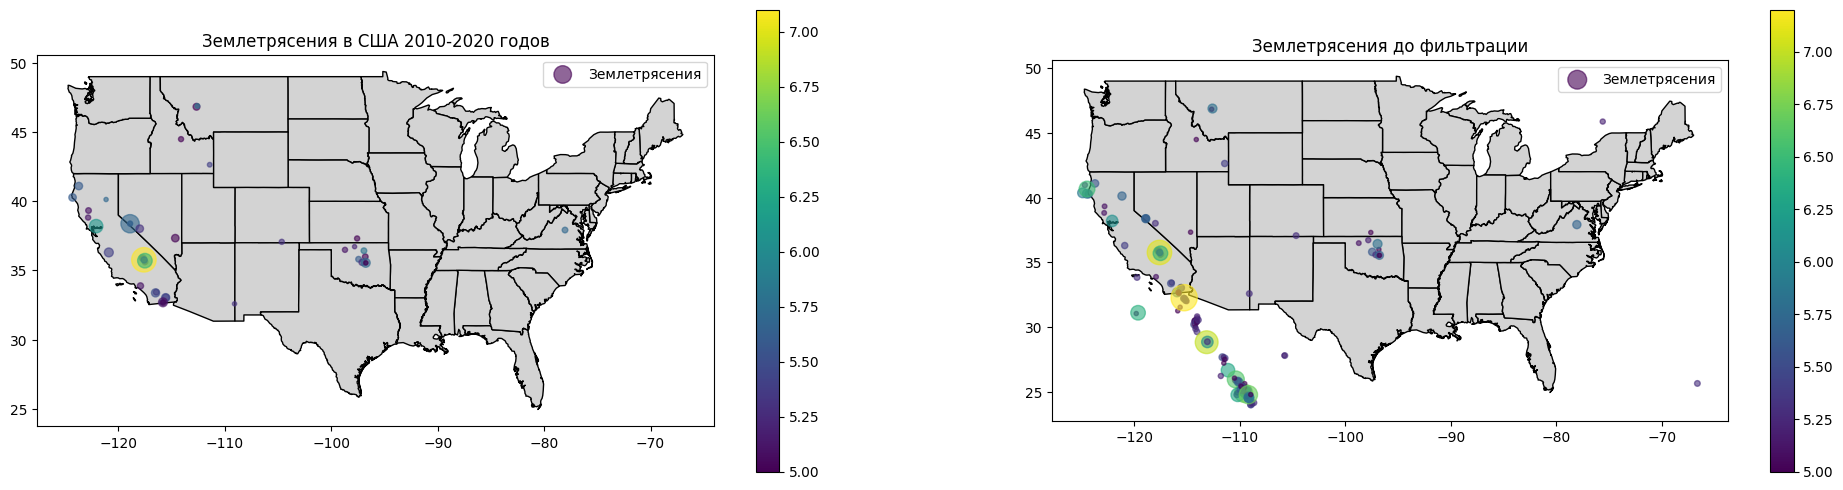

In [23]:
fig, (ax1, ax2) = plt.subplots(figsize=(24, 6), ncols=2)

# Show the us map
us_map.plot(ax=ax1, color='lightgrey', edgecolor='k')
us_map.plot(ax=ax2, color='lightgrey', edgecolor='k')

# Show the locations of earthquakes
quake_map_filtered.plot('magnitude',
                        ax=ax1,
                        alpha=0.6,
                        markersize=(quake_map['magnitude']/4)**10,
                        label='Землетрясения',
                        legend=True)

quake_map.plot('magnitude',
               ax=ax2,
               alpha=0.6,
               markersize=(quake_map['magnitude']/4)**10,
               label='Землетрясения',
               legend=True)

# Добавление легенды и заголовка
ax1.legend()
ax2.legend()
ax1.set_title("Землетрясения в США 2010-2020 годов")
ax2.set_title("Землетрясения до фильтрации")

plt.show()

# 3. Сбор сейсмических данных

В этом разделе я собираю данные с сейсмографов о землетрясениях, которые я нашел в 1 разделе.

Напишу функцию, которая будет искать сейсмологические данные по заданному землятресению. Будем брать записи за time_before секунд до и time_after секунд после землетрясения. Будем опрашивать сейсмографы в радиусе maxradius км от эпицентра. Минимальное расстояние между сейсмографами равно min_distance метров

In [57]:
from obspy.clients.fdsn.mass_downloader import CircularDomain, \
    Restrictions, MassDownloader
def download_waveform_data(event, time_before, time_after, maxradius, mindistance, mseed_storage, stationxml_storage):

    # Получаем релевантную информацию о событии
    starttime = event.preferred_origin().get('time') - time_before
    endtime = event.preferred_origin().get('time') + time_after
    latitude = event.preferred_origin().get('latitude')
    longitude = event.preferred_origin().get('longitude')

    # Задаем область поиска сейсмологических станций. Функция принимает значение
    # радиуса в градусах, поэтому переводим mаxradius из км в градусы
    maxradius = int(maxradius / 111.139)
    domain = CircularDomain(latitude=latitude, longitude=longitude,
                            minradius=0,
                            maxradius=maxradius)

    # Задаем ограничения поиска
    restrictions = Restrictions(
        # Задаем временные ограничения
        starttime=starttime,
        endtime=endtime,
        # Отбрасываем данные, которые составляют менее 95% заданного времени
        minimum_length = 0.95,
        # Если расстояние между сейсмографами меньше min_distance,
        # берем иформацию только с одного из них. Это исключает двойную запись
        # сейсмографов, включенных в несколько сейсмологических баз данных
        minimum_interstation_distance_in_m = mindistance
        )

    # Скачиваем данные
    mdl = MassDownloader(providers=['IRIS', 'SCEDC', 'NCEDC']) # Выбираю базы данных, которые буду опрашивать
    mdl.download(domain, restrictions,
                 threads_per_client=3, mseed_storage=mseed_storage,
                 stationxml_storage=stationxml_storage)

Далее я создаю каталог землетрясений, которые произошли на территории континентальных штатов. В цикле прохожусь по каталогу, и для каждого землетрясения запрашиваю сейсмические данные. Все полученные данные лежат на GitHub в папке Quake_Data. Рекомендую не перезапускать этот код, так как получение данных занимает несколько часов

In [63]:
# Создам новый каталог, содержащий только землетрясения в континентальных штатах
cat1 = obspy.core.event.catalog.Catalog()
for item in cat:
    if (item.preferred_origin().get('time') in quake_map['time'].values):
        cat1.append(item)

# Для каждого землетрясения запросим данные с базы данных
for item in cat1:
    download_waveform_data(
        item, time_before=5 * 60, time_after=3600, maxradius=200, mindistance=1000,
        mseed_storage='/Quake_Data/MSEED',
        stationxml_storage='/Quake_Data/XML')

Выходные данные были обрезаны до нескольких последних строк (5000).
[2024-06-08 22:35:52,826] - obspy.clients.fdsn.mass_downloader - INFO: Client 'SCEDC' - Successfully downloaded 14 channels (of 17)
[2024-06-08 22:35:52,826] - obspy.clients.fdsn.mass_downloader - INFO: Client 'SCEDC' - Successfully downloaded 14 channels (of 17)
[2024-06-08 22:35:52,826] - obspy.clients.fdsn.mass_downloader - INFO: Client 'SCEDC' - Successfully downloaded 14 channels (of 17)
[2024-06-08 22:35:52,826] - obspy.clients.fdsn.mass_downloader - INFO: Client 'SCEDC' - Successfully downloaded 14 channels (of 17)
[2024-06-08 22:35:52,826] - obspy.clients.fdsn.mass_downloader - INFO: Client 'SCEDC' - Successfully downloaded 14 channels (of 17)
[2024-06-08 22:35:52,826] - obspy.clients.fdsn.mass_downloader - INFO: Client 'SCEDC' - Successfully downloaded 14 channels (of 17)
[2024-06-08 22:35:52,826] - obspy.clients.fdsn.mass_downloader - INFO: Client 'SCEDC' - Successfully downloaded 14 channels (of 17)
[2024-06

Далее сжимаю собранные данные в архив и скачиваю

In [64]:
!zip -r /Quake_Data/comp.zip /Quake_Data

  adding: Quake_Data/ (stored 0%)
  adding: Quake_Data/XML/ (stored 0%)
  adding: Quake_Data/XML/AZ.WMC.xml (deflated 93%)
  adding: Quake_Data/XML/ZY.OCCM.xml (deflated 85%)
  adding: Quake_Data/XML/NC.CBR.xml (deflated 95%)
  adding: Quake_Data/XML/CI.SDR.xml (deflated 88%)
  adding: Quake_Data/XML/CI.SNO.xml (deflated 91%)
  adding: Quake_Data/XML/CI.DEV.xml (deflated 91%)
  adding: Quake_Data/XML/NX.STN17.xml (deflated 93%)
  adding: Quake_Data/XML/WR.SAC.xml (deflated 92%)
  adding: Quake_Data/XML/NX.STN16.xml (deflated 93%)
  adding: Quake_Data/XML/NC.PHR.xml (deflated 75%)
  adding: Quake_Data/XML/EN.ELM.xml (deflated 76%)
  adding: Quake_Data/XML/NC.CVL.xml (deflated 84%)
  adding: Quake_Data/XML/NN.SRVL.xml (deflated 96%)
  adding: Quake_Data/XML/8E.MB10.xml (deflated 94%)
  adding: Quake_Data/XML/NC.NHV.xml (deflated 84%)
  adding: Quake_Data/XML/NC.HBT.xml (deflated 75%)
  adding: Quake_Data/XML/CI.MSJ.xml (deflated 88%)
  adding: Quake_Data/XML/NC.JGR.xml (deflated 84%)
  a

In [67]:
files.download("/Quake_Data/comp.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Посмотрим, как выглядят скаченные данные. Построим график

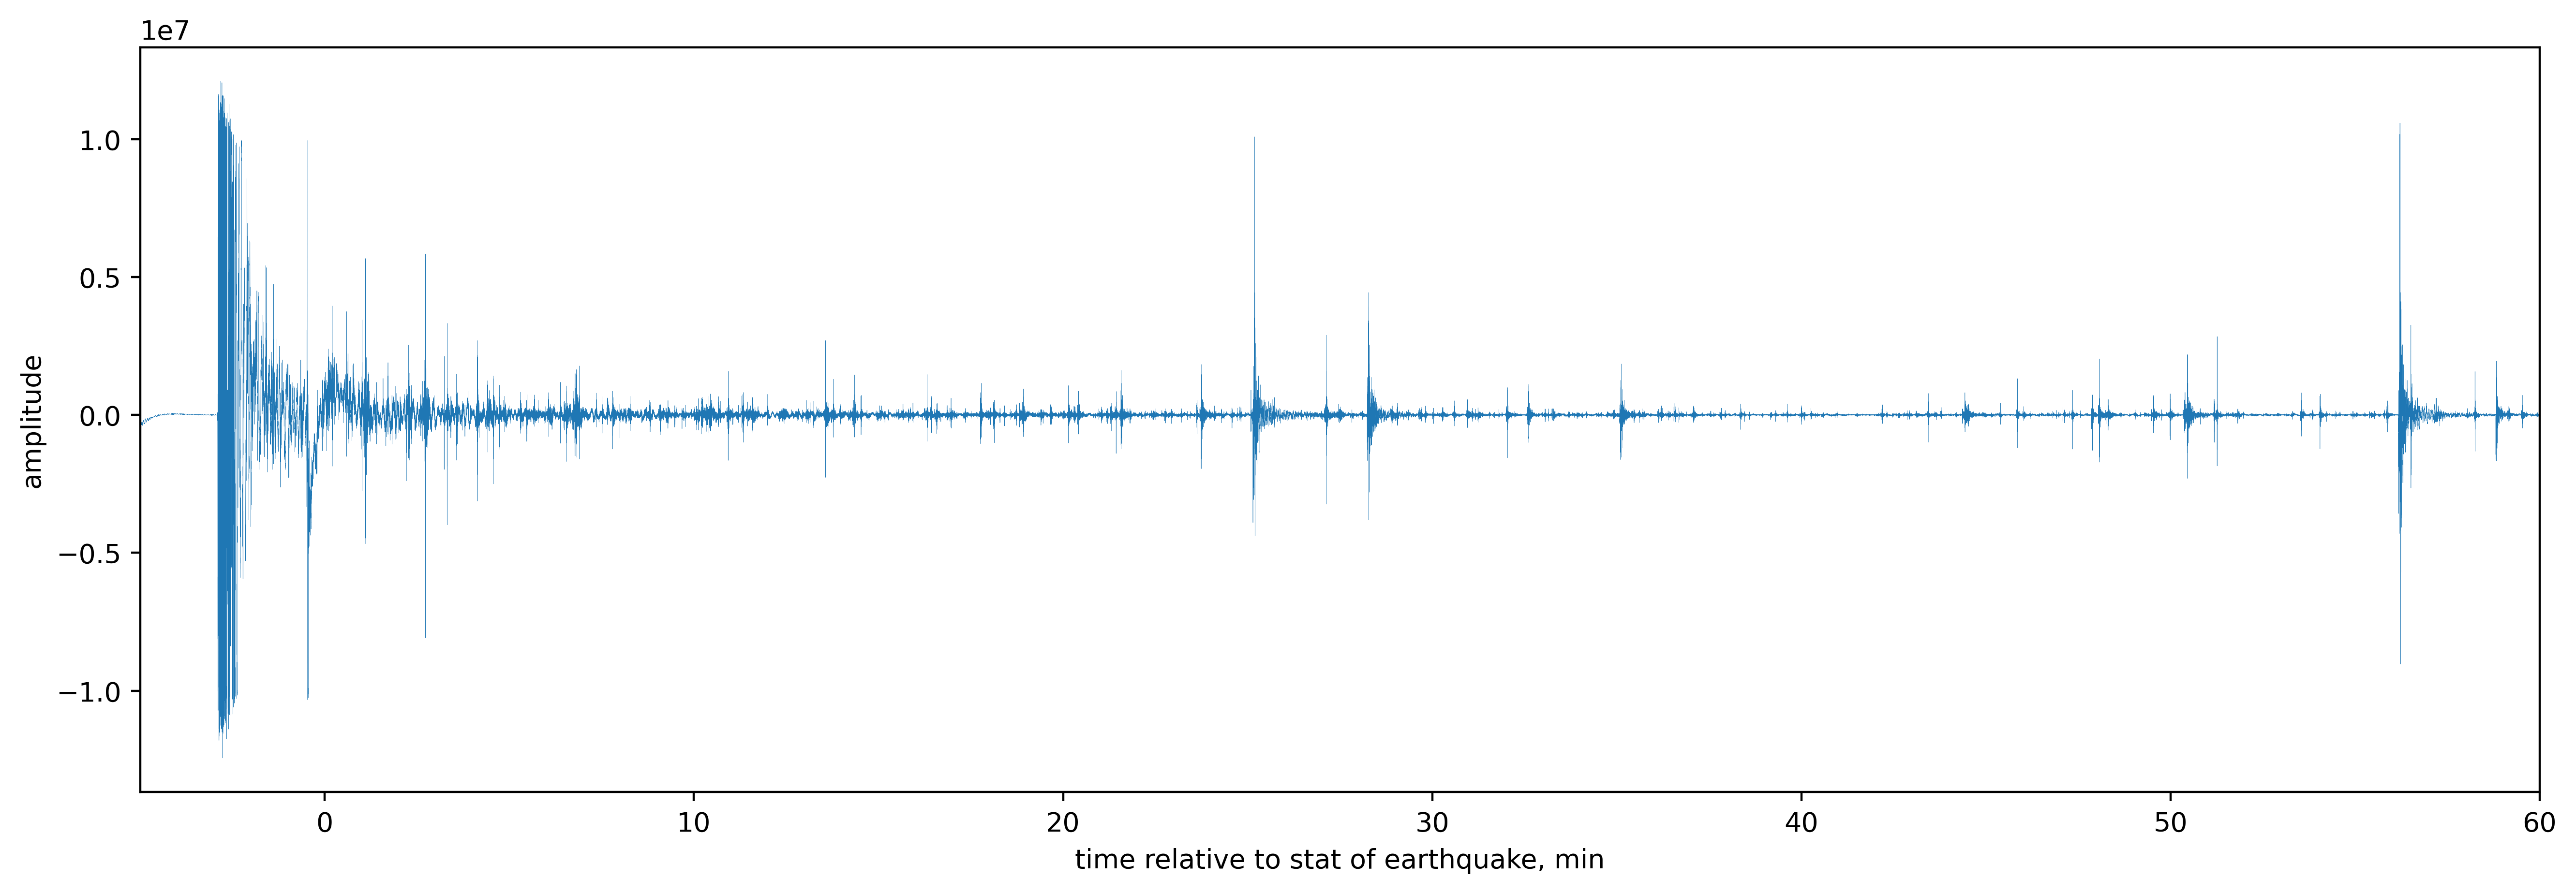

In [245]:
st = obspy.read('https://raw.githubusercontent.com/UtkaVPrudike/Data_Science_Final/main/Quake_Data/MSEED/CI.CLC..HHN__20190706T031748Z__20190706T042248Z.mseed')

fig, ax = plt.subplots(figsize=(16,5))
fig.set_dpi(400)

# по оси x откладываем время в минутах относительно начала землетрясения
# расчеты основаны на том, что я брал сейсмические наблюдения за 5 минут до
# и 60 минут после начала землетрясения
x = (np.arange(st[0].data.size) / st[0].stats.sampling_rate / 60) - 5
# по y откладываем сейсмические наблюдения
y = st[0].data
ax.plot(x, y, lw=0.1)

# Добавляем подписи и ограничение на y
ax.set_xlabel('time relative to stat of earthquake, min')
ax.set_ylabel('amplitude')
ax.set_xlim(-5,60)

plt.show()

# 4. Математические возможности

Скаченные данные - это амплитуда колебаний земли во время землетрясения. Чтобы узнать, какие частоты имели эти колебания, можно применить алгоритм Fast Fourier Transform (FFT). Определим функцию, которая будет выдавать результаты FFT. Функция принимает на вход:

*   сейсмические данные в виде obspy.stream
*   начало и конец промежутка времени, который мы исследуем
*   значение в герцах (Гц). Функция игнорирует частоты ниже этого значения в Гц (low pass фильтр).

Функция возвращает список из двух списков:

*   первый содержит все частоты, оцененные функцией
*   второй содержит магнитуды этих частот



In [152]:
def get_fourier_transform (st, start_time, end_time, lopass=0):
    # Получаем амплитудные данные
    data = st[0].data

    # Вычитаем среднее из данных. Это позволяет избежать ошибки, когда у частоты 0Гц магнитуда ненулевая
    data = data - np.mean(data)

    # Обычно сейсмографы собирают десятки или сотни наблюдений каждую секунду
    # (это фиксированное значение для каждого сейсмографа)
    # Чтобы корректно работать с индексами, переведем время в наблюдения

    sample_rate = st[0].data.size / (65 * 60) # Находим частоту наблюдений в секунду
    start_time = int((start_time + 5 * 60) * sample_rate) # переводим время в номер наблюдения
    end_time = int((end_time + 5 * 60) * sample_rate)

    # Выбираем интересующий нас промежуток времени
    data = data[start_time + 5*60 : end_time + 5*60]

    # Применяем FFT
    fft = np.fft.rfft(data) # Получаем амплитуду каждой частоты
    fft_frq = np.fft.rfftfreq(data.size, d= sample_rate / (end_time - start_time)) # Получаем оцененные частоты

    # Нас интересует магнитуда, а не амплитуда частот
    # Магнитуда частоты - это значение амплитуды по модулю
    fft = np.abs(fft)

    # low pass фильтр
    if(lopass > 0):
        # Переводим частоту в количество сэмплов
        lopass = int(lopass * sample_rate)
        # Заменяем данные до lopass нулями
        fft = np.pad(fft[lopass:], (lopass, 0), 'constant', constant_values=0)

    return [fft_frq, fft]



Посмотрим, что получилось. Построим график для тех же наблюдений, что мы смотрели в прошлом разделе

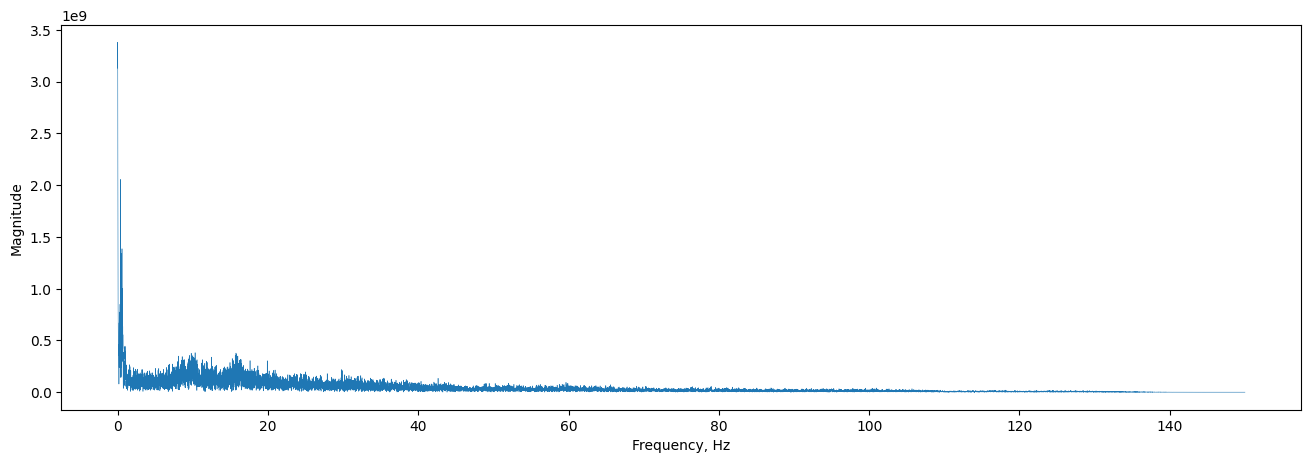

In [153]:
fft = get_fourier_transform(st, 0*60, 5*60, lopass = 0)

# Plot the resulting fft
fig, ax = plt.subplots(figsize=(16,5))

ax.plot(fft[0], fft[1], lw=0.4)

ax.set_ylabel('Magnitude')
ax.set_xlabel('Frequency, Hz')

plt.show()

Видим, что наиболее важными являются низкие частоты.

# 5. Графики

В этом разделе я буду строить спектрограммы. Спектрограмма - это тип графика, где по x отложено время, а по y - частота. Каждый пиксель имеет цвет, и цвет показывает интенсивность данной частоты в данный момент времени. О спектрограмме можно думать как о множестве графиков FFT (один мы рисовали в прошлом разделе), склеенных в один график

Сначала напишем функцию, которая будет создавать датафрейм, с помощью которого мы будем рисовать график. Функция принимает


*   сейсмические данные в виде obspy.stream
*   окно времени. Вся длина данных разбивается на такие окна, для каждого окна мы получаем частотную информацию с помощью get_fourier_transform()
*   значение lopass для функции get_fourier_transform()

Функция возвращает pandas.DataFrame, где  

*   столбцы - это промежутки времени, на которые мы разбили данные
*   строки - это частоты
*   значение каждой ячейки - это интенсивность данной частоты в данный промежуток времени







In [155]:
def get_spectrogram(st, window, lopass=0):
    # создаю пустой dataframe
    df = pd.DataFrame()

    # При скачивании данных, я выбрал интервал 5 минут до и 60 минут после
    # начала землетрясения, поэтому задаем эти временные рамки (в секундах)
    start_time = -5 * 60
    end_time = 60 * 60

    # Сделаем запись для первого промежутка времени,
    # чтобы потом использовать join для объединения новых dataframes с df
    fft = get_fourier_transform(st, start_time, start_time + window, lopass)

    # Запишем значение времени как среднее между началом и концом окна
    time_list = [start_time + window / 2] * fft[0].size

    # Запишем частотные данные в df
    df = pd.DataFrame({'time' : time_list,
                         'frq' : fft[0],
                         'magnitude' : fft[1]})

    # Используем pivot чтобы каждая частота стала названием строки
    df = df.pivot(index = 'frq', columns = 'time', values = 'magnitude')

    # Повторяем описанный выше процесс для всех оставшихся окон в цикле
    for start_time in np.arange(start_time + window, end_time - window, window):

        fft = get_fourier_transform(st, start_time, start_time + window, lopass)

        time_list = [start_time + window / 2] * fft[0].size

        df_2 = pd.DataFrame({'time' : time_list,
                             'frq' : fft[0],
                             'magnitude' : fft[1]})

        df_2 = df_2.pivot(index = 'frq', columns = 'time', values = 'magnitude')

        # объединяем dataframes
        df = df.join(df_2, on = 'frq')

    # Обычно у спектрограммы низкие частоты расположены внизу
    # оси y, а высокие - наверху. отсортируем dataframe по индексу
    # в убывающем порядке, чтобы добиться этого эффекта
    df = df.sort_index(ascending=False)

    return df

Напишем функцию draw_spectrogram(), которая будет рисовать спектрограмму по датафрейму, полученному в get_spectrogram(). Функция должна принимать на вход:

*   Название файла с сейсмическими данными в формате {Network}.{Station}.{location}.{channel}__{starttime}__{endtime}. По названию файла собирается ссылка, по которой функция читает файл
*   окно времени для функции get_spectrogram()
*   lopass для функции get_spectrogram()
*   тип шкалы частот - линейный 'lin' или логарифмический 'log'. Это определяет шкалу оси y на графике
*   тип шкалы цветов - линейный 'lin' или логарифмический 'log'. Это определяет шкалу нормировки цветов на графике
*   название цветовой палитры


In [158]:
def draw_spectrogram (file, window, lopass=0, freq_scale='log', color_scale='lin', colormap='viridis'):

    url = 'https://raw.githubusercontent.com/UtkaVPrudike/Data_Science_Final/main/Quake_Data/MSEED/' + file + '.mseed'

    # Получаем датафрейм
    df = get_spectrogram(st, window, lopass)

    # Создаем график
    fig, ax = plt.subplots(figsize = (12, 4.5))
    # Чтобы рассмотреть все детали, я устанавливаю высокое разрешение
    fig.set_dpi(200)

    # отрисовываем спектрограмму
    norm = None if color_scale == 'lin' else mpl.colors.LogNorm() # задаю шкалу нормировки цвета
    cax = ax.imshow(df, norm=norm, cmap=colormap, aspect='auto', extent=[-5, 60, 0, df.index[0]])

    # Добавляю шкалу цветов на график
    cbar = fig.colorbar(cax)

    # Добавляю подписи
    ax.set_xlabel('Time relative to start of earthquake, minutes')
    ax.set_ylabel('Frequency,  Hz')
    ax.set_title('Spectrogram of ' + file)

    # Устанавливаю шкалу частот
    if (freq_scale=='log'):
        ax.set_yscale('log')
        ymin = 0.01 if lopass < 0.01 else lopass
        ax.set_ylim([ymin, df.index[0]])
    else:
        ax.set_ylim([lopass, df.index[0]])

    plt.show()

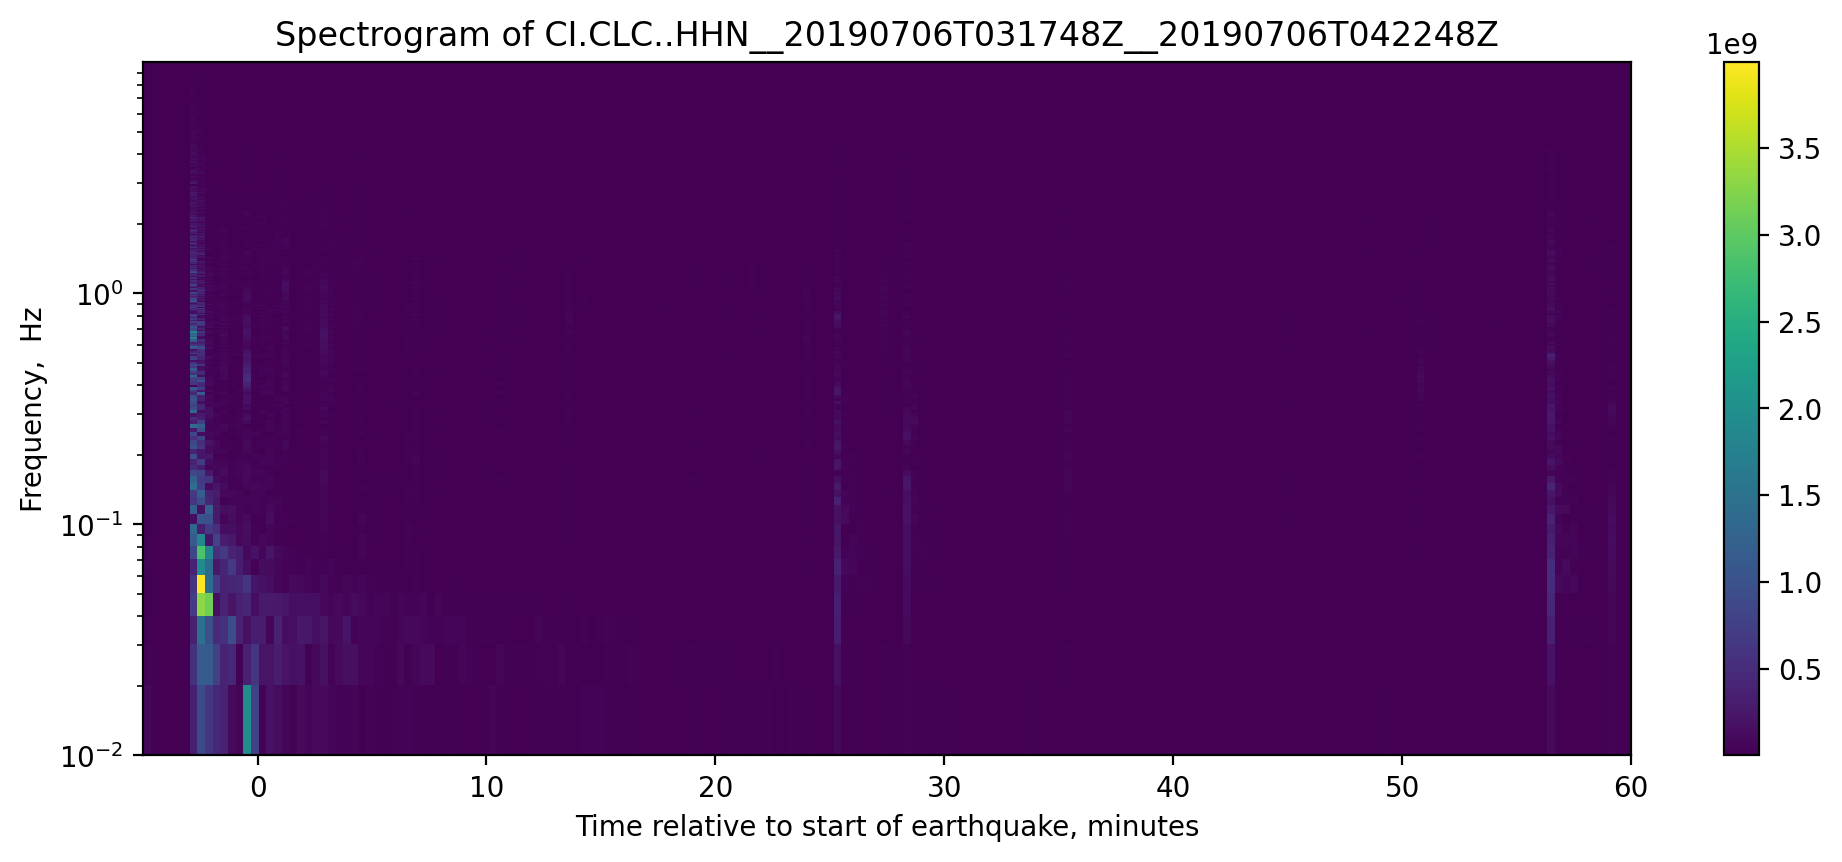

In [161]:
draw_spectrogram('CI.CLC..HHN__20190706T031748Z__20190706T042248Z', 20)

Теперь сделаем интерактивный график, чтобы смотреть на спектрограммы землетрясений. Названия доступных файлов можно посмотреть на странице моего проекта на GitHub, в папке Quake_data/MSEED. Мне нравится комбинировать логарифмическую шкалу частот и линейное нормирование цветов, или наоборот

In [160]:
file_selector = ipywidgets.Text(
    value='CI.CLC..HHN__20190706T031748Z__20190706T042248Z',
    placeholder='Type something',
    description='file :',
    disabled=False
)

window_slider = ipywidgets.IntSlider(
    value=60,
    min=1,
    max=3900,
    step=10,
    description='window :',
    layout={'width': '700px'},
    continuous_update=False)

low_pass_slider = ipywidgets.FloatSlider(
    value=0,
    min=0,
    max=3,
    step=0.02,
    description='low pass cutoff :',
    layout={'width': '700px'},
    continuous_update=False)

colormap_selector = ipywidgets.Dropdown(
    options=('viridis', 'plasma', 'inferno', 'magma', 'cividis', 'hot'),
    index=0,
    value='viridis',
    description='colormap :',
    layout={'width': '700px'},
    continuous_update=False
)

freq_scale_selector = ipywidgets.Dropdown(
    options=('log', 'lin'),
    index=0,
    value='log',
    description='freq scale :',
    layout={'width': '700px'},
    continuous_update=False
)

color_scale_selector = ipywidgets.Dropdown(
    options=('lin', 'log'),
    index=0,
    value='lin',
    description='color scale :',
    layout={'width': '700px'},
    continuous_update=False
)

ipywidgets.interact(
    draw_spectrogram,
    file=file_selector,
    window=window_slider,
    lopass=low_pass_slider,
    colormap=colormap_selector,
    freq_scale=freq_scale_selector,
    color_scale=color_scale_selector)

interactive(children=(Text(value='CI.CLC..HHN__20190706T031748Z__20190706T042248Z', description='file :', plac…

<function __main__.draw_spectrogram(file, window, lopass=0, freq_scale='log', color_scale='lin', colormap='viridis')>

# 6. Машинное обучение

## 6.1 Препроцессинг

Будем предсказывать расстояние между сейсмографом, зафиксировавшим землетрясение, и самим землетрясением.

Каждая запись с сейсмографа содержит более сотни тысяч значений, поэтому сначала нужно обработать эти данные и извлечь несколько полезных метрик. Напишем функцию gate_open(), которая будет возвращать момент времени, когда магнитуда землетрясения впервые достигает значения


*   или threshold * средняя магнитуда (method = 'mean')
*   или threshold * максимальная магнитуда (method = 'max')

In [29]:
def gate_open (st, threshold, method='mean'):
    # Сначала переведем данные из амплитуды в интенсивность,
    # чтобы все точки были положительные
    data = st[0].data
    data = np.abs(data)

    # Найдем среднюю интенсивность
    if (method == 'mean'):
        val = np.mean(data)
    else:
        val = np.max(data)

    # Найдем индекс, когда интенсивность впервые
    # превышает val * threshold
    y = np.argwhere(data >= val * threshold)[0][0]

    # Индекс преобразуем в время в секундах относительно начала землетрясения
    time = y / st[0].stats.sampling_rate - 5 * 60

    return time

Напишем функцию, которая позволит нам найти период максимальной интенсивности землетрясения. Функция должна принимать данные сейсмографа и длинну периода в секундах. Функция должна возвращать

*   или начало и конец периода максимальной интенсивности в секундах (return_type = 'time')
*    или значение максимальное значение скользящего среднего по интенсивности (return_type = 'intensity')

In [30]:
def max_intensity(st, window, return_type = 'time'):
    # Переведем данные из амплитуды в магнитуду
    data = st[0].data
    data = np.abs(data)

    # Найдем скользящее среднее с помощью pandas
    sample_rate = st[0].stats.sampling_rate
    moving_avg = pd.Series(data).rolling(int(window * sample_rate)).mean()

    # С помощью argmax найдем индекс в moving_avg,
    # соответствующий периоду максимальной интенсивности.
    # По индексу нетрудно вычислить время
    if (return_type == 'time'):
        end = np.argmax(moving_avg) / sample_rate - 5 * 60
        start = end - window
        return [start, end]
    else:
        return np.max(moving_avg)

Напишем функцию, которая возвращает частоту с наибольшей интенсивностью. В качестве периода выберем 5 минут максимальной интенсивности с помощью функции max_intensity

In [31]:
def most_prevalent_freq (st):
    # получим частотные данные для пяти минут максимальной интенсивности
    period = max_intensity(st, 5 * 60)
    fft = get_fourier_transform(st, period[0], period[1])
    # Выбираем частоту, соответсвующую максимальной магнитуде
    intense_frq = fft[0][np.argmax(fft[1])]

    return intense_frq

Далее я скачивал файлы с сейсмологическими данными, обрабатывал их и записывал результаты в DataFrame. Этот код не сработает, так как я брал файлы со своего гугл диска. Готовый DataFrame со всеми данными я сохранил в файл processed_data.csv. В этом датафрейме все колонки с префиксом data содержат информацию полученную от или о конкретном сейсмографе. Все колонки с префиксом quake содержат информацию о землетрясении, которое зафиксировал прибор

In [26]:
# Аутентификация в pydrive2 API
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Подключаю гугл диск к коллабу
drive.mount('/content/gdrive')

In [35]:
# Получаю список файлов на диске
file_list = drive.ListFile({'q' : "'1EkEhMFBxyVWE7amaQ8jRA11hMl2n_-B5' in parents and trashed=False"}).GetList()
# создаю список, в который буду записывать строки dataframe в виде словарей
row_list = []
for f in file_list:
    try:
        # Читаю файл
        st = obspy.read('/content/gdrive/MyDrive/Data_Science_Final/Quake_Data/MSEED/%s' % (f['title']))

        # создаю словарь для строки
        dict1 = {}
        # записываю метаданные о файле
        dict1['data_network'] = st[0].stats.network
        dict1['data_station'] = st[0].stats.station
        dict1['data_channel'] = st[0].stats.channel
        dict1['data_sample_rate'] = st[0].stats.sampling_rate
        dict1['data_quality'] = st[0].stats.mseed['dataquality']

        # записываю метрики с помощью определенных ранее функций
        dict1['data_10%_mean_mag'] = gate_open(st, 0.1)
        dict1['data_mean_mag'] = gate_open(st, 1)
        dict1['data_10%_max_mag'] = gate_open(st, 0.1, method='max')
        dict1['data_max_mag'] = gate_open(st, 1, method='max')
        dict1['data_intensity_period'] = max_intensity(st, 5 * 60)[0]
        dict1['data_max_intensity'] = max_intensity(st, 1, 'intensity')
        dict1['data_smooth_intensity'] = max_intensity(st, 5 * 60, 'intensity')
        dict1['data_long_freq'] = most_prevalent_freq(st)[0]
        dict1['data_intense_freq'] = most_prevalent_freq(st)[1]

        # ищу файл StationXML, содержащий информацию о сейсмологической станции, на которой были сделаны наблюдения
        # собираю название станции и читаю нужный файл
        station_file_name = st[0].stats.network + '.' + st[0].stats.station + '.xml'
        station = obspy.read_inventory(f'/content/gdrive/MyDrive/Data_Science_Final/Quake_Data/XML/{station_file_name}')
        # внутри файла StationXML беру информацию о конкретном канале, который производил наблюдения
        # сначала собираю название канала
        channel_name = st[0].stats.network + '.' + st[0].stats.station + '.' + st[0].stats.location + '.' + st[0].stats.channel
        # с помощью названия канала получаю информацию о его расположении
        dict1['data_longitude'] = station.get_channel_metadata(channel_name)['longitude']
        dict1['data_latitude'] = station.get_channel_metadata(channel_name)['latitude']
        dict1['data_local_depth'] = station.get_channel_metadata(channel_name)['local_depth']

        # Расчитываю время начала землетрясения
        time = st[0].stats.starttime + 5 * 60
        # Фильтрую каталог, оставляя только землетрясения в промежутке 1 секунды от рассчитаного времени
        # Вероятность того, что из 48 землетрясений за 10 лет два произошли с промежутком меньше секунды крайне мало
        filter_cat1 = cat1.filter(f'time > {time - 1}',
                                  f'time < {time + 1}')
        event = filter_cat1[0] # это то самое землетрясение, которое зафиксировал прибор

        # записываем информацию о землетрясении
        dict1['quake_longitude'] = event.preferred_origin().get('longitude')
        dict1['quake_latitude'] = event.preferred_origin().get('latitude')
        dict1['quake_time'] = event.preferred_origin().get('time').timestamp
        dict1['quake_magnitude'] = event.preferred_magnitude().get('mag')

        # Есть два основных типа магнитуды, но на разных базах данных они обозначены по-разному
        # Перевожу тип магнитуды в логическое значение, где
        # False - это локальная магнитуда, а
        # True - это абсолютная магнитуда
        magnitude_type = event.preferred_magnitude().get('magnitude_type')
        if (magnitude_type == 'ML' or
            magnitude_type == 'Ml' or
            magnitude_type == 'ml'):

            dict1['quake_magnitude_type'] = False
        else:
            dict1['quake_magnitude_type'] = True

        # Добавляю словарь в список строк
        row_list.append(dict1)

    # Иногда у наблюдения не было соответсвующего файла StationXML с информацией о приборе
    # Тогда возникала одна из двух ошибок, и эта строчка пропускалась
    except FileNotFoundError:
        continue
    except Exception:
        continue

# создаю датафрейм и сохраняю значения в файл processed_data.csv
df = pd.DataFrame(row_list)
df.to_csv('processed_data.csv')

Читаем файл с обработанными данными

In [197]:
df = pd.read_csv('https://raw.githubusercontent.com/UtkaVPrudike/Data_Science_Final/main/processed_data.csv')

Выбираем данные, кодируем строковые данные, делим на трейн и тест

In [220]:
# Запишем расстояние в км между сейсмографом и землетрясением в новую колонку
df['distance'] = np.sqrt((df['quake_longitude'] - df['data_longitude']) ** 2 + (df['quake_latitude'] - df['data_latitude']) ** 2) * 111.139

# Выберем интересующие нас колонки
X = df[['data_sample_rate', 'data_quality', 'data_mean_mag',
        'data_max_mag', 'data_intensity_period', 'data_max_intensity',
        'data_smooth_intensity', 'data_intense_freq', 'data_local_depth',
        'quake_time', 'quake_magnitude', 'quake_magnitude_type']]
Y = df['distance']

# Закодируем столбец data_quality с помощью OneHotEncoder
enc = OneHotEncoder().fit(X[['data_quality']])
quality_enc = pd.DataFrame(enc.transform(X[['data_quality']]).toarray(), columns=enc.get_feature_names_out())
X = X.join(quality_enc)
X = X.drop(columns=['data_quality']) # отбрасываем старую колонку data quality
X = X.drop(columns=['data_quality_M']) # отбрасываем одну из колонок, созданных OneHotEncoder, так как иначе получим линейную связность

# Разделим данные на трейн и тест
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=513, shuffle=True)

Теперь скейлим данные с помощью StandardScaler

In [221]:
sc = StandardScaler()

def scaler(X_train, X_test):
    X_train_sc = sc.fit_transform(X_train.select_dtypes(include=np.number)) # выбираем колонки с численными признаками и скейлим
    X_test_sc = sc.transform(X_test.select_dtypes(include=np.number))
    X_train_sc = np.nan_to_num(X_train_sc)
    X_test_sc = np.nan_to_num(X_test_sc)
    return X_train_sc, X_test_sc


X_train_sc, X_test_sc = scaler(X_train, X_test)

Посмотрим на корреляции между переменными. Для этого построим heatmap

In [222]:
X_train.corr().style.background_gradient(cmap='coolwarm').format(precision = 2)

,data_sample_rate,data_mean_mag,data_max_mag,data_intensity_period,data_max_intensity,data_smooth_intensity,data_intense_freq,data_local_depth,quake_time,quake_magnitude,quake_magnitude_type,data_quality_D,data_quality_Q
data_sample_rate,1.00,0.06,-0.04,-0.01,-0.05,-0.08,-0.03,-0.05,0.24,-0.07,0.08,-0.17,-0.04
data_mean_mag,0.06,1.00,-0.22,-0.18,0.07,-0.02,-0.06,-0.02,-0.14,0.14,0.33,-0.05,0.11
data_max_mag,-0.04,-0.22,1.00,0.61,-0.08,-0.03,-0.04,-0.02,0.15,0.05,-0.09,0.02,0.04
data_intensity_period,-0.01,-0.18,0.61,1.00,-0.03,0.14,-0.01,-0.03,0.10,0.04,-0.05,0.02,0.02
data_max_intensity,-0.05,0.07,-0.08,-0.03,1.00,0.61,-0.15,-0.05,0.18,0.24,-0.04,-0.10,0.13
data_smooth_intensity,-0.08,-0.02,-0.03,0.14,0.61,1.00,-0.14,-0.08,0.08,0.15,-0.05,-0.06,0.04
data_intense_freq,-0.03,-0.06,-0.04,-0.01,-0.15,-0.14,1.00,0.19,-0.00,-0.08,-0.00,-0.05,-0.05
data_local_depth,-0.05,-0.02,-0.02,-0.03,-0.05,-0.08,0.19,1.00,0.03,0.06,0.02,-0.15,-0.04
quake_time,0.24,-0.14,0.15,0.10,0.18,0.08,-0.00,0.03,1.00,0.06,-0.29,-0.23,0.03
quake_magnitude,-0.07,0.14,0.05,0.04,0.24,0.15,-0.08,0.06,0.06,1.00,0.12,-0.02,0.08


Видим, что максимальная и сглаженная интенсивности значительно скорреллированы. Также, момент достижения максимальной интенсивности и момент наступления сглаженной максимальной интенсивности значительно скорреллированы

## 6.2 Линейная регрессия

Попробуем использовать линейную регрессию для предсказания расстояния между сейсмографом и землетресением

In [233]:
model = LinearRegression()
fit = model.fit(X_train_sc, Y_train) # фит
Y_pred = model.predict(X_test_sc) # предикт
print("Mean absolute error: %.2f" % mean_absolute_error(Y_test, Y_pred))

Mean absolute error: 27.17


Я собирал данные с сейсмографов в радиусе 200км от землетрясения. Поэтому МАЕ в 27км выглядит очень грустно. Несмотря на это, посмотрим на коэффициенты модели

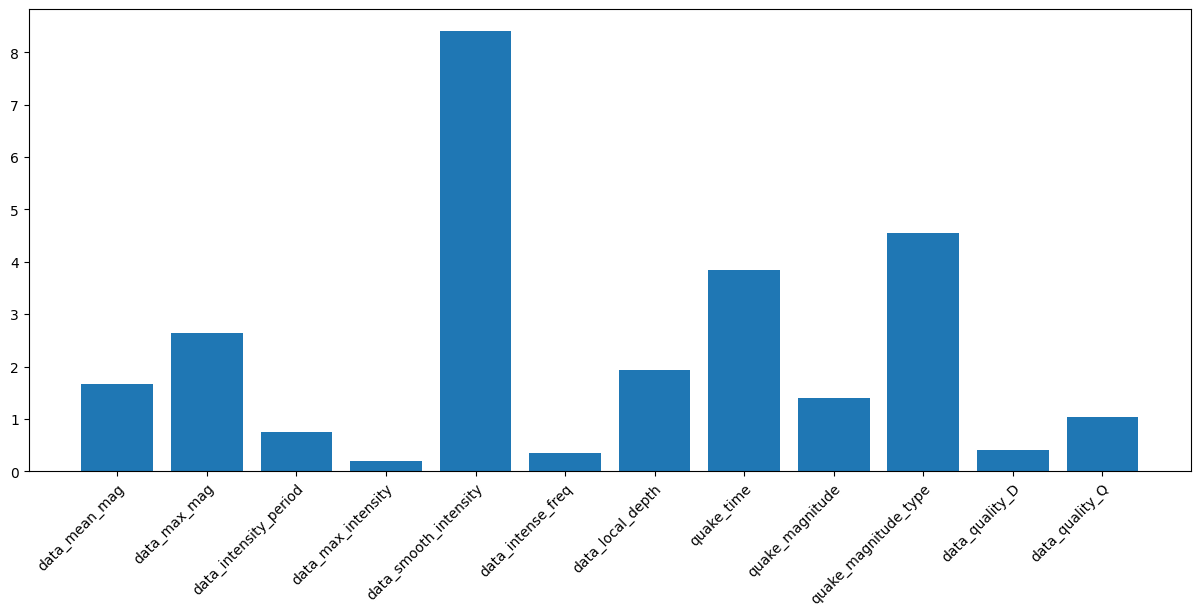

In [226]:
fig, ax = plt.subplots(figsize=(15, 6))
# рисую бар плот
plt.bar(np.arange(1,len(X_train.columns)), np.abs(fit.coef_))
# рисую подписи на оси x
ax.set_xticks(np.arange(1,len(X_train.columns)), labels=X_train.columns.values[1:])
# поворачиваю подписи на 45 градусов
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.show()

Видим, что больше всего на расстояние влияет максимальное значение сглаженной интенсивности. На втором месте тип магнитуды землетрясения, на третьем - время землетрясения

## 6.3 Градиентный бустинг

Попробуем более мощную модель, градиентный бустинг. В цикле попробуем различные значения параметров модели

In [246]:
best_mae = 10000000
best_params = {}
best_coef = -10
depths = [3, 5, 7, 10, 15, 20] # глубина дерева
n_estimators = [10, 15, 17, 20, 23, 25, 50, 70] # количество итераций
learning_rates = [0.05, 0.1, 0.15, 0.5, 0.9] # скорость обучения
for n_estimator in n_estimators: # проходим по всем значениям, ищем те, которые уменьшают ошибку
    for learning_rate in learning_rates:
        for depth in depths:
          gb = GradientBoostingRegressor(max_depth=depth, n_estimators=n_estimator, learning_rate=learning_rate, loss='absolute_error')
          gb.fit(X_train_sc, Y_train)
          Y_pred_gb = gb.predict(X_test_sc)
          new_mae = mean_absolute_error(Y_test, Y_pred_gb)
          if (new_mae < best_mae):
              best_mae = new_mae
              best_params = {'n_estimators' : n_estimator, 'learning_rate' : learning_rate, 'depth' : depth}
print(f'Best MAE is {best_mae} with parameters {best_params}')

Best MAE is 7.5735355880979975 with parameters {'n_estimators': 70, 'learning_rate': 0.15, 'depth': 15}


Градиентный бустинг значительно улучшил результаты! Модель в среднем ошибается всего на 7.5 км

# 7. Графы

Построим граф, в котором вершинами будут различные сейсмологические комплексы. Между комплексами есть ребро, если они зарегестрировали одно и то же землетрясение. Сделаем взвешенный граф, вес ребра равен количеству раз, когда сейсмологические комплексы регестрировали одно и то же землетрясение

In [164]:
# Создадим словарь, где ключами являются ребра графа,
# а значениями являются веса ребер
edges_dict = dict()

# Группирую по времени землетрясения, так как время двух землетрясений не может совпадать
# Уникальные значения в колонке data_network внутри каждой группы - это сейсмологические комплексы,
# которые зафиксировали одно и то же землетрясение
for group in df.groupby('quake_time')['data_network'].unique():
    length = len(group)
    # Прохожу по всем парам комплексов в группе
    for i in range(len(group)):
        for j in range(i + 1, len(group)):
            # Если пары (с точностью до перестановок) еще нет в словаре, добавляю ее со значением 1
            if ((group[i], group[j]) not in edges_dict.keys() and
                (group[j], group[i]) not in edges_dict.keys()):
                edges_dict[(group[i], group[j])] = 1
            # Если пара (с точностью до перестановок) есть в словаре, увеличиваю ее значение на 1
            else:
                try:
                    edges_dict[(group[i], group[j])] += 1
                except KeyError:
                    edges_dict[(group[j], group[i])] += 1

# Теперь создам список кортежей, где каждый кортеж содержит ребро и его вес
edges = []
for edge, val in edges_dict.items():
    edge = (edge[0], edge[1], val)
    edges.append(edge)

#создам граф из полученного списка
G = nx.Graph()
G.add_weighted_edges_from(edges)

Нарисуем полученный граф, цвет ребра задается весом ребра. Фиолетовый соответствует низкому весу, зеленый - высокому.

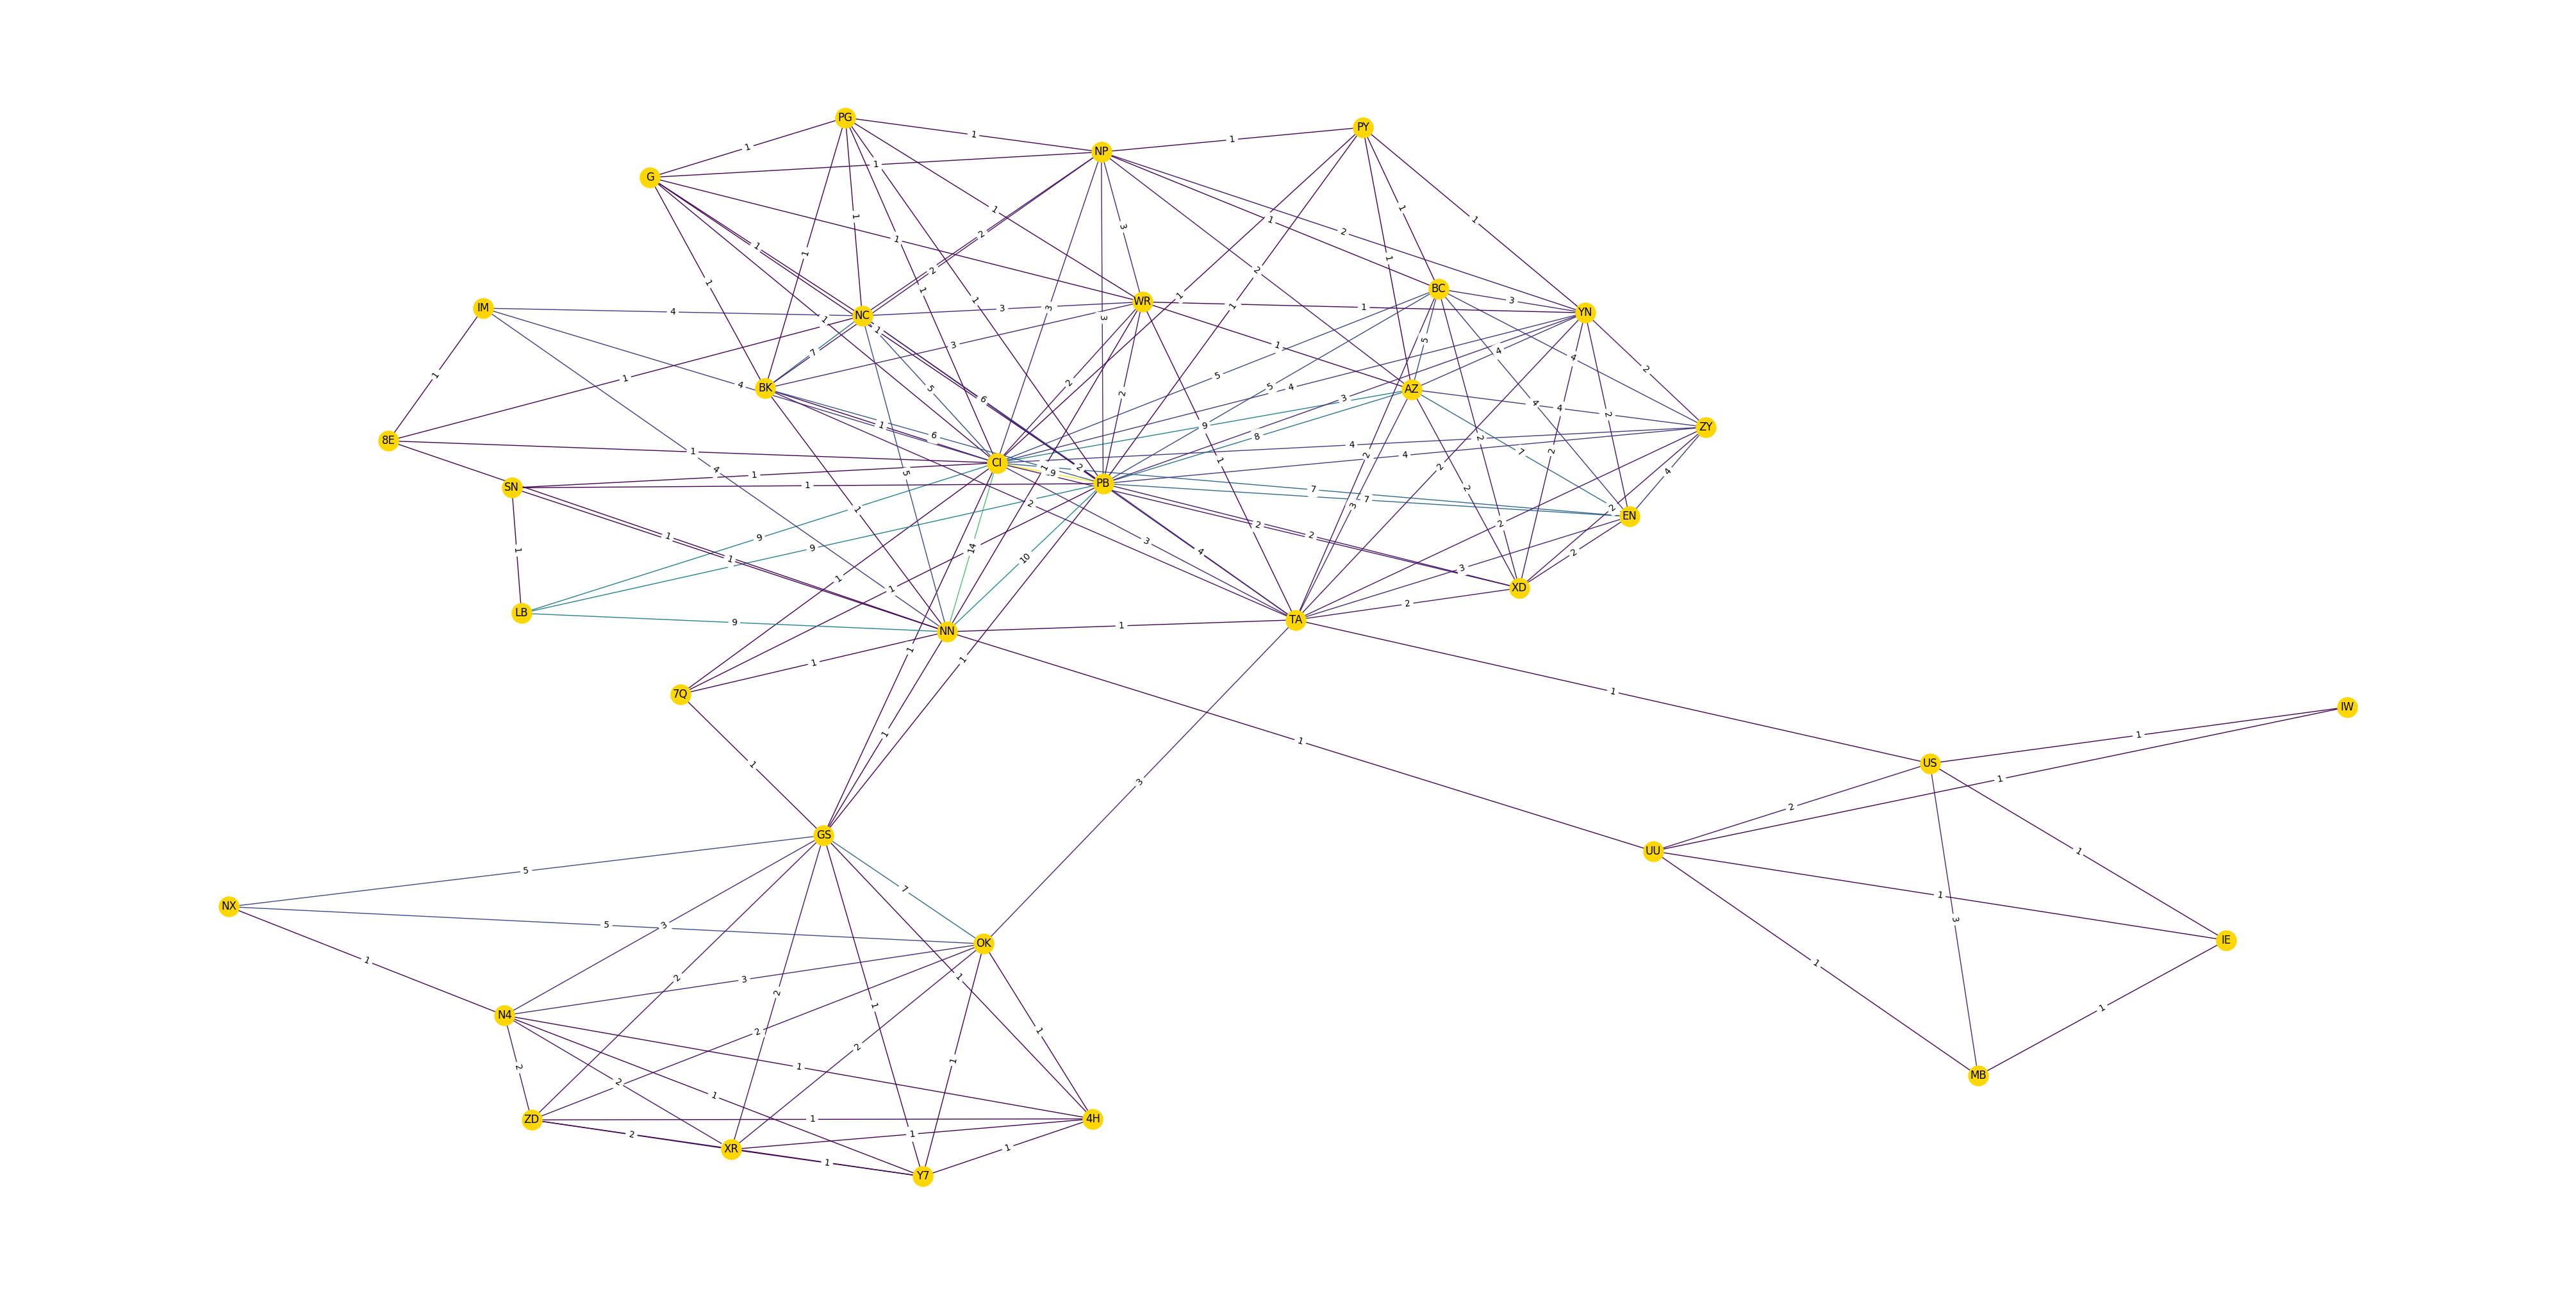

In [191]:
plt.figure(figsize=(40,20))

pos = nx.nx_pydot.graphviz_layout(G)  # рассчитываем позиции узлов

edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

nx.draw(G, pos, edgelist=edges, edge_color=weights, with_labels=True, node_size=500, node_color='gold')  # рисуем граф

edge_weight = nx.get_edge_attributes(G, "weight")  # получаем список весов
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_weight)  # добавляем веса на картинку
plt.show()

Теперь посмотрим на некоторые метрики графа, а именно на степень вершин и на betweenness centrality вершин. Сначала найдем вершину, укоторой эти значения максимальны

In [230]:
highest_degree_node = max(G.nodes, key=G.degree)
print(f'{highest_degree_node} - это вершина с наибольшей степенью. Ее степень равна {G.degree(highest_degree_node)}')

CI - это вершина с наибольшей степенью. Ее степень равна 22


In [234]:
betweenness = nx.centrality.betweenness_centrality(G)
highest_betweenness_node = max(G.nodes, key=betweenness.get)
print(f'{highest_betweenness_node} - это вершина с наибольшой betweenness centrality. Ее betweenness centrality = {betweenness[highest_betweenness_node]}')

GS - это вершина с наибольшой betweenness centrality. Ее betweenness centrality = 0.2344452932688226


Теперь посмотрим на распределение степеней вершин в графе. Построим bar plot

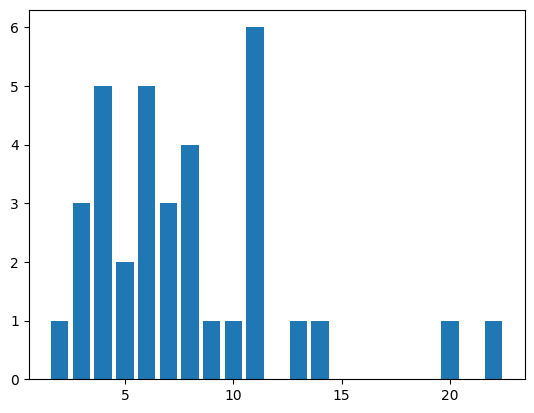

In [237]:
degree_sequence = [G.degree(n) for n in G.nodes]

degree_counts = Counter(degree_sequence)

min_degree, max_degree = min(degree_counts.keys()), max(degree_counts.keys())
plot_x = list(range(min_degree, max_degree + 1))
plot_y = [degree_counts.get(x, 0) for x in plot_x]

plt.bar(plot_x, plot_y)
plt.show()

Посмотрим на распределение betweenness centrality для вершин графа. Построим гистограмму

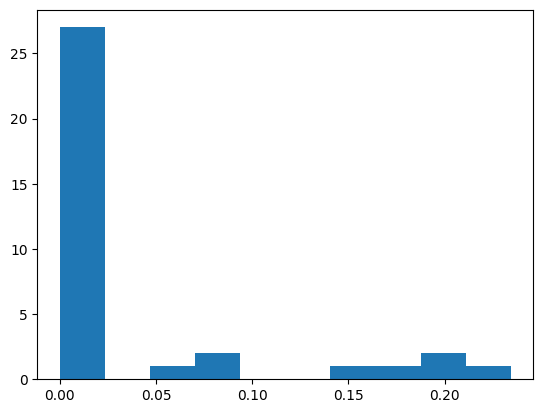

In [236]:
betweenness = nx.centrality.betweenness_centrality(G)
betweenness_sequence = list(betweenness.values())
counts, bins, patches = plt.hist(betweenness_sequence, bins=10)